In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Bidirectional, Dropout, Dense, BatchNormalization
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

2023-12-25 00:00:33.768565: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-25 00:00:33.768603: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-25 00:00:33.769143: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-25 00:00:33.772594: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-25 00:00:34.314230: W tensorflow/compiler/tf2

In [2]:
# Загрузка данных
train_input_df = pd.read_csv("data/train.csv")
test_input_df = pd.read_csv("data/test.csv")

train_input_df.head(5)

,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^
0,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
1,2,Amazing!,This soundtrack is my favorite music of all ti...
2,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
3,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."
4,2,an absolute masterpiece,I am quite sure any of you actually taking the...


In [3]:
len(train_input_df), len(test_input_df)

(3599999, 399999)

In [4]:
max_rows = 50_000
val_size = 0.2
test_size = 0.2

# Создание случайной выборки и одновременное разделение данных
# 0.8 на train И val
train_sample_df = train_input_df.sample(n=int(max_rows * (1 - test_size)))

train_val = pd.DataFrame()
train_val["class"] = train_sample_df.iloc[:, 0]
train_val["reviev"] = train_sample_df.iloc[:, 2]

# 0.8 на train И 0.2 на val
train, val = train_test_split(train_val, test_size=val_size)

# 0.2 идет на тест
test_sample_df = test_input_df.sample(n=int(max_rows * test_size))

test = pd.DataFrame()
test["class"] = test_sample_df.iloc[:, 0]
test["reviev"] = test_sample_df.iloc[:, 2]

# del train_input_df
# del test_input_df
# del train_val

train.head(5)

,class,reviev
2187470,2,I love this iPod. I was very skeptical when I ...
3014044,2,This book really tells us what the Public Heal...
3475338,1,"Measures approximately 8"" H x 6"" ID x 11 1/2"" ..."
2182990,1,I was excited to find this product on sale bec...
262243,1,Adult one size fits all - not over a shoe size...


In [5]:
len(train), len(val), len(test)

(32000, 8000, 10000)

In [6]:
# Число каждого класса (1 - Негативный, 2 - Позитивный)
train["class"].value_counts()

class
2    16002
1    15998
Name: count, dtype: int64

In [7]:
val["class"].value_counts()

class
1    4004
2    3996
Name: count, dtype: int64

In [8]:
test["class"].value_counts()

class
1    5057
2    4943
Name: count, dtype: int64

In [9]:
# Разделение данных на текст и метки
def text_class_split(df, class_col_name):
    return df.drop(class_col_name, axis=1), df[class_col_name]


train_text, train_classes = text_class_split(train, "class")
val_text, val_classes = text_class_split(val, "class")
test_text, test_classes = text_class_split(test, "class")

# Сброс индекса
train_text.reset_index(drop=True, inplace=True)
val_text.reset_index(drop=True, inplace=True)
test_text.reset_index(drop=True, inplace=True)

In [10]:
import re


# Удаление всех символов кроме букв
def remove_marks(text):
    text = re.sub(r'[^A-Za-zÀ-ú ]+', '', text)
    return text.lower()


train_text["reviev"] = train_text["reviev"].apply(remove_marks)
val_text["reviev"] = val_text["reviev"].apply(remove_marks)
test_text["reviev"] = test_text["reviev"].apply(remove_marks)
train_text.head(5)

,reviev
0,i love this ipod i was very skeptical when i o...
1,this book really tells us what the public heal...
2,measures approximately h x id x odim not s...
3,i was excited to find this product on sale bec...
4,adult one size fits all not over a shoe size ...


In [11]:
# Приводим в форму (x, ) (Из df делаем serias)
train_text = train_text.squeeze()
val_text = val_text.squeeze()
test_text = test_text.squeeze()

# Кодирование меток
encoder = LabelEncoder()
train_y = encoder.fit_transform(train_classes)
val_y = encoder.transform(val_classes)
test_y = encoder.transform(test_classes)

In [12]:
# Использованеи Tokenizer для преобразования в
max_words = 10000
max_len = 100
embedding_dim = 64


tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_text)
                            
sequences = tokenizer.texts_to_sequences(train_text)
train_x = pad_sequences(sequences, maxlen=max_len) 

sequences = tokenizer.texts_to_sequences(val_text)
val_x = pad_sequences(sequences, maxlen=max_len)

sequences = tokenizer.texts_to_sequences(test_text)
test_x = pad_sequences(sequences, maxlen=max_len)

In [13]:
epochs = 15
batch_size = 128

model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
    # рекуррентный слой 128 нейронами
    Bidirectional(LSTM(units=128, return_sequences=True)), 
    # Отключают 30% процентов нейронов защищая от переобучения
    Dropout(0.5),
    Bidirectional(LSTM(units=64)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])


# Компиляция модели с выбором оптимизатора, функции потерь и метрики
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# Обучение модели на обучающих данных и оценка на валидационных данных
history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, validation_data=(val_x, val_y))

# Оценка производительности модели на тестовых данных
test_loss, test_accuracy = model.evaluate(test_x, test_y)

print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

2023-12-25 00:01:17.706509: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-25 00:01:17.733096: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-25 00:01:17.733138: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-25 00:01:17.736109: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-25 00:01:17.736150: I external/local_xla/xla/stream_executor

Epoch 1/15


2023-12-25 00:01:21.439221: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2023-12-25 00:01:22.011137: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f29c0753bc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-25 00:01:22.011168: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2023-12-25 00:01:22.014062: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1703444482.043175   30179 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


250/250 [==============================] - 15s 49ms/step - loss: 0.5343 - accuracy: 0.7099 - val_loss: 0.4016 - val_accuracy: 0.8216
Epoch 2/15
250/250 [==============================] - 8s 33ms/step - loss: 0.3566 - accuracy: 0.8507 - val_loss: 0.3556 - val_accuracy: 0.8478
Epoch 3/15
250/250 [==============================] - 7s 29ms/step - loss: 0.3007 - accuracy: 0.8816 - val_loss: 0.3495 - val_accuracy: 0.8580
Epoch 4/15
250/250 [==============================] - 7s 27ms/step - loss: 0.2689 - accuracy: 0.8973 - val_loss: 0.4459 - val_accuracy: 0.8309
Epoch 5/15
250/250 [==============================] - 7s 27ms/step - loss: 0.2418 - accuracy: 0.9093 - val_loss: 0.3642 - val_accuracy: 0.8531
Epoch 6/15
250/250 [==============================] - 6s 25ms/step - loss: 0.2182 - accuracy: 0.9218 - val_loss: 0.3883 - val_accuracy: 0.8540
Epoch 7/15
250/250 [==============================] - 6s 25ms/step - loss: 0.1963 - accuracy: 0.9296 - val_loss: 0.4128 - val_accuracy: 0.8385
Epoch 8/1

313/313 [==============================] - 2s 7ms/step


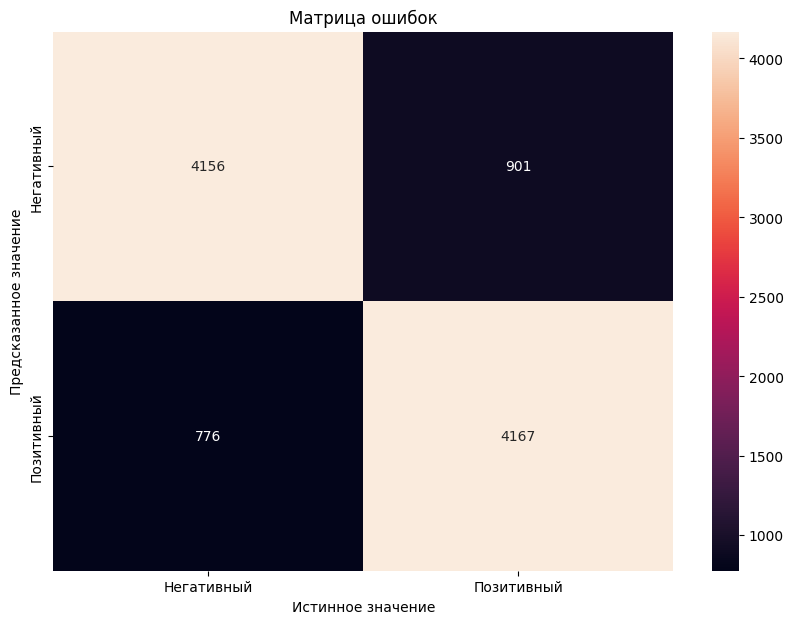

In [23]:

# Получение предсказаний модели для тестовых данных
predictions = model.predict(test_x)
predictions


# Вероятность того что комментарий позитивный
predicted_classes = [1 if p > 0.5 else 0 for p in predictions]

# Создание матрицы ошибок
cm = confusion_matrix(test_y, predicted_classes)

# Визуализация матрицы ошибок
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Негативный', 'Позитивный'], yticklabels=['Негативный', 'Позитивный'])
plt.title('Матрица ошибок')
plt.xlabel('Истинное значение')
plt.ylabel('Предсказанное значение')
plt.show()


In [36]:
def predict(text): 
    text = remove_marks(text)       
    sequences = tokenizer.texts_to_sequences([text])
    x_new = pad_sequences(sequences, maxlen=max_len)
    
    prediction = model.predict(x_new)[0][0]
    if prediction > 0.5:
        print("Положительный комментарий")
    else:
        print("Отрицательный комментарий")
    
    
predict("Terrible product! Disgusting quality!")

1/1 [==============================] - 0s 17ms/step
Отрицательный комментарий


In [37]:
predict("I love this phone. It holds the power for a very long time")

1/1 [==============================] - 0s 17ms/step
Положительный комментарий


In [38]:
predict("The seller is just an idiot. They didn't send what I ordered")

1/1 [==============================] - 0s 17ms/step
Отрицательный комментарий
